# Setup

In [1]:
# import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import operator

# import specific components from scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor

# enhanced stats functions
from scipy import stats

# for ease of data profiling
from pandas_profiling import ProfileReport

# for removal of warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# print environment setup details
print(f"pandas version  : {pd.__version__}")  # 1.4.3
print(f"numpy version   : {np.__version__}")  # 1.23.1

pandas version  : 1.4.3
numpy version   : 1.23.1


Here, we also set the seed for numpy's random number generator such that our results are fully reproducible. This is because the other libraries (e.g. scikit-learn) use this random number generator, so if we set the seed we will always generate the same random numbers in the same sequence.

Thus, whenever we run the notebook from top-to-bottom, we will end up with the *exact* same results! 

In [3]:
SEED = 12345
np.random.seed(SEED)

# Data Loading
To load in the data for this project, read in data directly from the provided URL into a variable called `abalone` as a pandas DataFrame. The first two rows of the DataFrame should look like this:

|     | Sex | Length | Diameter | Height | Whole weight | Shucked weight | Viscera weight | Shell weight | Rings |
| --- | --- | ------ | -------- | ------ | ------------ | -------------- | -------------- | ------------ | ----- |
| **0**| M  | 0.455  | 0.365    | 0.095  | 0.5140       | 0.2245         | 0.1010         | 0.150        | 15    |
| **1**| M  | 0.350  | 0.265    | 0.090  | 0.2255       | 0.0995         | 0.0485         | 0.070        |  7    |
| **2**| F  | 0.530  | 0.420    | 0.135  | 0.6770       | 0.2565         | 0.1415         | 0.210        |  9    |
| **3**| M  | 0.440  | 0.365    | 0.125  | 0.5160       | 0.2155         | 0.1140         | 0.155        | 10    |
| **4**| I  | 0.330  | 0.255    | 0.080  | 0.2050       | 0.0895         | 0.0395         | 0.055        |  7    |

In [4]:
# provided url to read csv file from directly
url = ("https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data")
# read in data from the provided url without 'header'
abalone = pd.read_csv(url, header=None)
# provided column names to add to your dataset
abalone.columns = ["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings",]

In [5]:
# make sure data was read in properly and matches above table
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


The model will be using purely physical measurements to predict the age of the abalone. Since sex is not a purely physical measure, let's remove it from the dataset.

In [6]:
# delete the 'Sex' column using .drop
abalone = abalone.drop("Sex", axis=1)

# EDA
Now it is time for you to practice your EDA skills! Take a look at the Quest 3 Quiz, and answer the questions on the results of your EDA on the dataset.

This time, you don't get the data dictionary! You have to go look at the dataset's website and take a look yourself, like you would have to if this was a real project.

Here's the website where the dataset came from: [the UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/abalone).

In [7]:
# optional: use pandas-profiling to do quick first pass at EDA
profile = ProfileReport(abalone, title="Abalone Dataset Profiling Report")
# create html file to view report
profile.to_file("abalone_dataset_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
# conduct any other EDA that you need to in order to get a good feel for the data
abalone.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


With the EDA you have conducted, answer the following questions from the quiz. Note that these questions do not cover everything you should be looking for when doing EDA, they are just to give you an idea of what EDA would look like on such a dataset.
## Question 1
What is the median whole weight of the abalones in the dataset?

In [12]:
# calculate median of whole weight of abalones
median_whole_weight = abalone['Whole weight'].median()

# Print the median whole weight
print(median_whole_weight)

0.7995


## Question 2
How old is an abalone with a `Rings` value of 9?

hint: you'll have to look at the dataset website! (under 'attribute information')

## Question 3
Which bin range has the most number of observations for the variable 'Rings'?

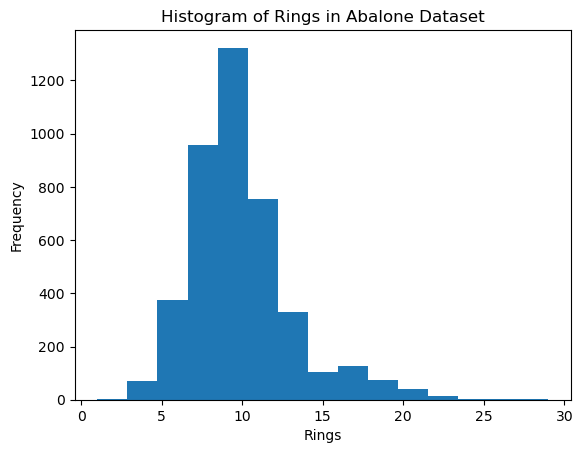

In [13]:
# plot a histogram of the `Rings` with 15 bins
plt.hist(abalone['Rings'], bins=15)

# Add labels and title
plt.xlabel('Rings')
plt.ylabel('Frequency')
plt.title('Histogram of Rings in Abalone Dataset')

plt.show()

## Question 4
Which independent variable is least correlated to the dependent variable `Rings` ?

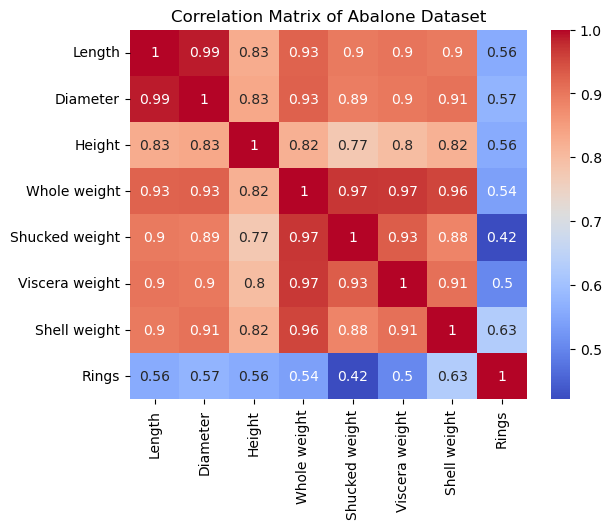

In [14]:
# plot correlation matrix to get a sense of what variables are correlated to 'Rings' using corr()
corr_matrix = abalone.corr()

# Plot the correlation matrix as a heatmap using seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Add title
plt.title('Correlation Matrix of Abalone Dataset')

# Show the plot
plt.show()


# Data Wrangling
Excellent! Now separate our independent variables into a variable called `X`, and our target variable `Rings` into a variable called `y`.

In [15]:
# split up our variables
X = abalone.drop("Rings", axis=1)
X = X.values
y = abalone["Rings"]
y = y.values

In [16]:
# the resulting shapes of X and y should be (4177, 7) and (4177,) respectively
print(X.shape)
print(y.shape)

(4177, 7)
(4177,)


Now we need to split up our data into training and test data. Using scikit-learn's `train_test_split` function, using a `test_size` of 0.2 (i.e. 20% of data in test set), and ensure that the random state is set to our seed from above.

Documentation for `train_test_split()` can be found here: https://scikit-learn.org/1.1/modules/generated/sklearn.model_selection.train_test_split.html

In [17]:
# do the train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

Now let's verify to make sure you split your data identically. 

## Question 5
There are __ rows in the train data and __ rows in the test data

In [18]:
# finding out the shape of the 'X_train' array will be able to check the number of records in the train data
print("Number of records in the train data:", X_train.shape[0])

Number of records in the train data: 3341


In [19]:
# finding out the shape of the 'y_test' array will be able to check the number of records in the test data
print("Number of records in the test data:", y_test.shape[0])


Number of records in the test data: 836


# Modelling
So now let's make our model! Check the docs for the `KNeighborsRegressor()` scikit-learn function with a starting 'k' value of '3' (this can be any other number). Then fit the training data on it.

Documentation for `KNeighborsRegressor()` can be found here: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [20]:
# instantiate kNN classifier model with the 'k' value 
knn = KNeighborsRegressor(n_neighbors=3)
# fit the training data (X_train, y_train) to it
knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)

## Question 6
What is the predicted number of rings of the first abalone in the `X_test` dataset?

In [23]:
# obtain predictions of the model using the test data set 'X_test'
y_pred = knn.predict(X_test)
# obtain the first prediction made
first_pred = y_pred[0]

print(first_pred)

15.666666666666666


# Evaluation
Now we need to evaluate how our model did. Let's start by calculating the root-mean-square error (RMSE). The RMSE of a prediction is computed as follows:

    1. Compute the difference between each data point’s actual value and predicted value.
    2. For each difference, take the square of this difference.
    3. Sum all the squared differences.
    4. Take the square root of the summed value.

## Question 7
What is the RMSE of the model based on the test data?

In [25]:
# Calculate the MSE by comparing the model predictions 'y_pred' against the test data 'y_test'
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE by taking the squareroot of MSE
rmse = np.sqrt(mse)
rmse

2.375417924000521

Another way to evaluate our model is to visualise and compare the predictions using simple scatter plots

We can do this by first plotting a scatter plot of the `Length` and `Diameter` variables of the `X_test` dataset against the `Rings` target variable. In addition, we color the points based on the predicted `Rings` variables from the model prediction `y_pred`. 

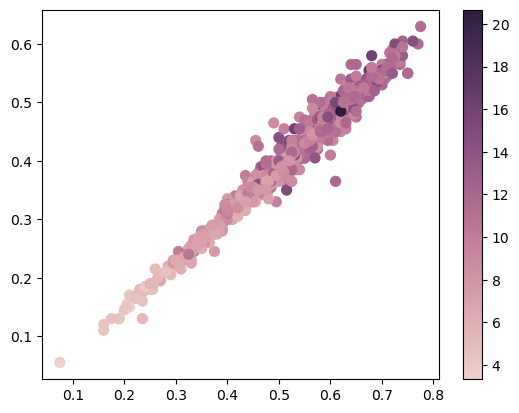

In [26]:
# specify the color scheme for the scatterplot
cmap = sns.cubehelix_palette(as_cmap=True)
# plots axis
f, ax = plt.subplots()
# plots the `Length` and 'Diameter' variables of the 'X_test' set against 'Rings', as well as prediction points 'y_pred'
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, s=50, cmap=cmap)
# specify color to points
f.colorbar(points)
plt.show()

Next, we can do plot another scatter plot of the `Length` and `Diameter` variables of the `X_test` dataset against the `Rings` target variable. However, now color the points based on the actual `Rings` variable from `y_test`. 

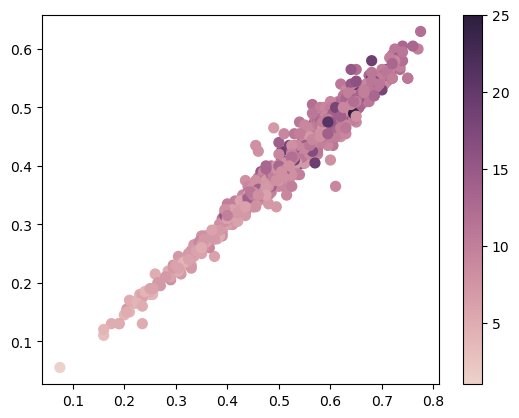

In [27]:
# specify the color scheme for the scatterplot
cmap = sns.cubehelix_palette(as_cmap=True)
# plots axis
f, ax = plt.subplots()
# plots the `Length` and 'Diameter' variables of the 'X_test' set against 'Rings', as well as prediction points 'y_test'
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cmap)
# specify color to points
f.colorbar(points)
plt.show()

## Question 8
Based on the scatterplots, is the model learning the trends in ages of abalones correctly?

# Optional Discussion
While our model has learned some of the relationships from the data, it still can be improved. What could we try in subsequent models? 

We could use ensemble methods like Bagging, a method that fits a large number of the models with slight fit variations, to improve the RMSE rate. Bagging is typically used for decision trees, but kNN works perfectly as well.

Ensemble methods are often more performant than single models. One model can be wrong from time to time, but the average of a hundred models should be wrong less often. The errors of different individual models are likely to average each other out, and the resulting prediction will be less variable.

In [28]:
# create new kNN regressor instance for bagging
bagged_knn = KNeighborsRegressor(n_neighbors=3)

# create a new instance with 100 estimators using the bagged_knn model
bagging_model = BaggingRegressor(bagged_knn, n_estimators=100)

In [29]:
# fit the training data (X_train, y_train) to it
bagging_model.fit(X_train, y_train)

BaggingRegressor(base_estimator=KNeighborsRegressor(n_neighbors=3),
                 n_estimators=100)

In [30]:
# Now we can make a prediction and calculate the RMSE to see if it improved:
test_preds_grid = bagging_model.predict(X_test)

test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
test_rmse

2.3228974389674897

Now that we have used bagging to improve the RMSE score of the model by a little, there are always more ways to improve the model performance. Here's a non-exhaustive list of ideas:
1. We could improve the accuracy of the model by optimising the 'k' value through cross-validation
2. Further feature engineering to clean the dataset before training (Feature scaling, removing outliers, removing poorly correlated features)

As with Quest 2, attempting further improvements are left as an exercise to the reader ;)

# Prepare your Submission
Congratulations, you made it to the end of this lesson! Be sure to complete the few remaining quiz questions, and prepare your submission:
1. Replace the value of the `NAME` variable with your StackUp name and run the cells below.
2. Restart your notebook, then run it from start to end.
3. Take a screenshot of the output from the last cell in this notebook. Make sure your screenshot shows your taskbar/dock (i.e. take a screenshot of the whole screen, not just the window).

Remember to obtain the RMSE score of your model before bagging

In [31]:
# replace this with your stackup name
NAME = "DannyGZM"

Name                : DannyGZM
Calculated root-mean-square error: 2.375417924000521


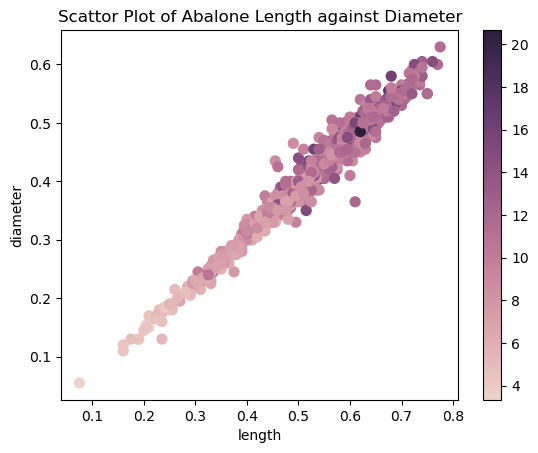

In [32]:
# fill out this cell appropriately, then take a screenshot of the result
print(f"{'Name':<20}: {NAME}")
# RMSE score
print(f"Calculated root-mean-square error: {rmse}")
# specify the color scheme for the scatterplot
cmap = sns.cubehelix_palette(as_cmap=True)
# plots axis
f, ax = plt.subplots()
# plots the `Length` and 'Diameter' variables of the 'X_test' set against 'Rings', as well as prediction points 'y_pred'
points = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, s=50, cmap=cmap)
# specify color to points
f.colorbar(points)
plt.title("Scattor Plot of Abalone Length against Diameter")
plt.xlabel("length")
plt.ylabel("diameter")
plt.show()